In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys, torch, pickle, csv
import numpy as np
import scipy as sp
sys.path.append('/lfs/1/danfu/metal')
sys.path.append('/lfs/1/danfu/sequential_ws')
from metal.metrics import metric_score
from torch.nn.functional import normalize
from DP.label_model import *
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
device = torch.device('cuda:0')

# Load Data

In [4]:
L_train_path = '/lfs/1/danfu/esper/app/data/shot_detection_weak_labels/L_train_100_windows_high_pre_downsampled.npz'
L_dev_path = '/lfs/1/danfu/esper/app/data/shot_detection_weak_labels/L_val_windows_high_pre_downsampled.npz'
Y_dev_path = '/lfs/1/danfu/esper/app/data/shot_detection_weak_labels/Y_val_windows_high_pre_downsampled.npy'
L_test_path = '/lfs/1/danfu/esper/app/data/shot_detection_weak_labels/L_test_windows_high_pre_downsampled.npz'
Y_test_path = '/lfs/1/danfu/esper/app/data/shot_detection_weak_labels/Y_test_windows_high_pre_downsampled.npy'

stride = 1
L_train_raw = sp.sparse.load_npz(L_train_path).todense()[::stride]
L_dev_raw = sp.sparse.load_npz(L_dev_path).todense()
Y_dev_raw = np.load(Y_dev_path)
L_test_raw = sp.sparse.load_npz(L_test_path).todense()
Y_test_raw = np.load(Y_test_path)

T = 5

L_train = torch.FloatTensor(L_train_raw[:L_train_raw.shape[0] - (L_train_raw.shape[0] % T)]).to(device)
L_dev = torch.FloatTensor(L_dev_raw[:L_dev_raw.shape[0] - (L_dev_raw.shape[0] % T)]).to(device)
Y_dev = torch.FloatTensor(Y_dev_raw[:Y_dev_raw.shape[0] - (Y_dev_raw.shape[0] % T)]).to(device)
L_test = torch.FloatTensor(L_test_raw[:L_test_raw.shape[0] - (L_test_raw.shape[0] % T)]).to(device)
Y_test = torch.FloatTensor(Y_test_raw[:Y_test_raw.shape[0] - (Y_test_raw.shape[0] % T)]).to(device)
m_per_task = L_train.size(1)
n_frames_train = L_train.size(0)
n_patients_train = n_frames_train//T
n_frames_dev = L_dev.size(0)
n_patients_dev = n_frames_dev//T
n_frames_test = L_test.size(0)
n_patients_test = n_frames_test//T

# MRI_data_naive = {'Li_train': (L_train.unsqueeze(2) == torch.FloatTensor([-1,1,0]).to(device).unsqueeze(0).unsqueeze(0)).argmax(2),
#                   'Li_dev': (L_dev.unsqueeze(2) == torch.FloatTensor([-1,1,0]).to(device).unsqueeze(0).unsqueeze(0)).argmax(2),
#                   'R_dev': (Y_dev.unsqueeze(1) == torch.FloatTensor([-1,1]).to(device).unsqueeze(0)).argmax(1),
#                   'm':m_per_task, 'T':1,
#                  }

# don't need to transform the raw data
MRI_data_naive = {'Li_train': L_train.long().to(device),
                  'Li_dev': L_dev.long().to(device),
                  'R_dev': Y_dev.long().to(device),
                  'Li_test': L_test.long().to(device),
                  'R_test': Y_test.long().to(device),
                  'm':m_per_task, 'T':1,
                 }
MRI_data_naive['class_balance'] = normalize((MRI_data_naive['R_dev'].unsqueeze(1)==torch.arange(2, device=device).unsqueeze(0)).sum(0).float(), 
                                            dim=0, p=1)
MRI_data_temporal = {'Li_train': MRI_data_naive['Li_train'].view(n_patients_train, (m_per_task*T)),
                     'Li_dev': MRI_data_naive['Li_dev'].view(n_patients_dev, (m_per_task*T)),
                     'R_dev': MRI_data_naive['R_dev']*(2**T-1),
                     'Li_test': MRI_data_naive['Li_test'].view(n_patients_test, (m_per_task*T)),
                     'R_test': MRI_data_naive['R_test']*(2**T-1),
                     'm': m_per_task * T, 'T': T,
                    } 
MRI_data_temporal['class_balance'] = normalize((MRI_data_temporal['R_dev'].unsqueeze(1)==torch.arange(2**T, device=device).unsqueeze(0)).sum(0).float(), 
                                                dim=0, p=1)

# Naive Model

In [12]:
MRI_data_naive['class_balance']

tensor([0., 1.], device='cuda:0')

In [5]:
naive_model = DPLabelModel(m=m_per_task, 
                           T=1,
                           edges=[],
                           coverage_sets=[[0,]]*m_per_task,
                           mu_sharing=[[i,] for i in range(m_per_task)],
                           phi_sharing=[],
                           device=device,
                           # class_balance=MRI_data_naive['class_balance'], 
                           seed=0)
optimize(naive_model, L_hat=MRI_data_naive['Li_train'], num_iter=3000, lr=4.087885261759692e-05,
         momentum=0.9, clamp=True, seed=2)

iteration=0 loss=50.6702766418457
iteration=300 loss=8.80715274810791
iteration=600 loss=3.66485595703125
iteration=900 loss=1.8281009197235107
iteration=1200 loss=0.9653668999671936
iteration=1500 loss=0.6120548844337463
iteration=1800 loss=0.4767417907714844
iteration=2100 loss=0.40450260043144226
iteration=2400 loss=0.3607012629508972
iteration=2700 loss=0.3310929536819458
iteration=2999 loss=0.30959445238113403


# Timeseries model

In [5]:
valid_target = Y_dev.long()
T = 5

feasible_y = np.array([[-1, -1, -1, -1, -1],
        [-1,  1, -1, -1, -1],
        [ 1, -1, -1, -1, -1],
        [ 1,  1, -1, -1, -1],
        [-1, -1,  1, -1, -1],
        [-1,  1,  1, -1, -1],
        [ 1, -1,  1, -1, -1],
        [ 1,  1,  1, -1, -1],
        [-1, -1, -1,  1, -1],
        [-1,  1, -1,  1, -1],
        [ 1, -1, -1,  1, -1],
        [ 1,  1, -1,  1, -1],
        [-1, -1,  1,  1, -1],
        [-1,  1,  1,  1, -1],
        [ 1, -1,  1,  1, -1],
        [ 1,  1,  1,  1, -1],
        [-1, -1, -1, -1,  1],
        [-1,  1, -1, -1,  1],
        [ 1, -1, -1, -1,  1],
        [ 1,  1, -1, -1,  1],
        [-1, -1,  1, -1,  1],
        [-1,  1,  1, -1,  1],
        [ 1, -1,  1, -1,  1],
        [ 1,  1,  1, -1,  1],
        [-1, -1, -1,  1,  1],
        [-1,  1, -1,  1,  1],
        [ 1, -1, -1,  1,  1],
        [ 1,  1, -1,  1,  1],
        [-1, -1,  1,  1,  1],
        [-1,  1,  1,  1,  1],
        [ 1, -1,  1,  1,  1],
        [ 1,  1,  1,  1,  1]])

feasible_y[feasible_y==-1] = 0
feasible_y = feasible_y.tolist()
possibilities = list(map(lambda l : ''.join(map(str,l)), feasible_y))

class_balance = np.empty(2 ** T)
#compute class balance from dev set and use laplace smoothing

valid_target_copy = np.copy(valid_target)
valid_target_copy[valid_target_copy == 2] = 0

assert len(valid_target_copy) % T == 0
num_windows = len(valid_target_copy) / T

freq = {}
for i in range(0, len(valid_target_copy), T):
    s = ''.join(map(str,valid_target_copy[i:i+T]))
    if s in freq:
        freq[s] += 1
    else:
        freq[s] = 1

for i in range(len(class_balance)):
    if possibilities[i] in freq and freq[possibilities[i]] > 5:
        class_balance[i] = (freq[possibilities[i]] + 1) / (num_windows + len(possibilities))
    else:
        class_balance[i] = 0.

In [6]:
%%time
best = None
for iterations in [1, 5,10, 25, 50, 100, 200]:
    for learning_rate in [1e-4, 1e-5, 1e-6, 1e-7]:
        print(iterations, learning_rate)
        max_seed = 10
        temporal_models = [None,]*max_seed
        for seed in range(max_seed):
            print(seed)
            markov_model = DPLabelModel(m=m_per_task*T, 
                                        T=T,
                                        edges=[(i,i+m_per_task) for i in range((T-1)*m_per_task)],
                                        coverage_sets=[[t,] for t in range(T) for _ in range(m_per_task)],
                                        mu_sharing=[[t*m_per_task+i for t in range(T)] for i in range(m_per_task)],
                                        phi_sharing=[[(t*m_per_task+i, (t+1)*m_per_task+i)
                                                      for t in range(T-1)] for i in range(m_per_task)],
                                        device=device,
                                        class_balance=torch.tensor(class_balance).float().to(device),
                                        seed=seed)
            optimize(markov_model, L_hat=MRI_data_temporal['Li_train'], num_iter=iterations,
                     lr=1e-5, momentum=0.8, clamp=True, 
                     verbose=iterations >= 10, seed=seed)
            temporal_models[seed] = markov_model

        for seed, model in enumerate(temporal_models):
            Li_dev = torch.LongTensor(MRI_data_temporal['Li_dev'].cpu().numpy())
            R_pred_frame_label = model.predict_element_proba(Li_dev.to(device)) #predict per element

            scores = [iterations, seed, model]
            for metric in ['accuracy', 'f1', 'recall', 'precision']:
                score = metric_score(Y_dev.cpu(), np.round(R_pred_frame_label), metric)
                print(f"{metric.capitalize()}: {score:.3f}")

                scores.append(score)
                
            model.flip_params()
            R_pred_frame_label = model.predict_element_proba(Li_dev.to(device)) #predict per element

            for metric in ['accuracy', 'f1', 'recall', 'precision']:
                score = metric_score(Y_dev.cpu(), np.round(R_pred_frame_label), metric)
                print(f"{metric.capitalize()}: {score:.3f}")

                scores.append(score)
            
            model.flip_params()

            if best == None or scores[4] > max(best[4], best[8]) or scores[8] > max(best[4], best[8]):
                best = scores
            print()

print(best)

1 0.0001
0
1
2
3
4
5
6
7
8
9
Accuracy: 0.029
F1: 0.278
Recall: 0.201
Precision: 0.447
Accuracy: 0.000
F1: 0.000
Recall: 0.000
Precision: 0.000

Accuracy: 0.020
F1: 0.163
Recall: 0.136
Precision: 0.204
Accuracy: 0.025
F1: 0.172
Recall: 0.176
Precision: 0.168

Accuracy: 0.055
F1: 0.341
Recall: 0.377
Precision: 0.311
Accuracy: 0.011
F1: 0.097
Recall: 0.073
Precision: 0.145

Accuracy: 0.051
F1: 0.424
Recall: 0.355
Precision: 0.524
Accuracy: 0.016
F1: 0.075
Recall: 0.110
Precision: 0.057

Accuracy: 0.028
F1: 0.254
Recall: 0.194
Precision: 0.368
Accuracy: 0.003
F1: 0.035
Recall: 0.018
Precision: 0.455

Accuracy: 0.006
F1: 0.038
Recall: 0.040
Precision: 0.035
Accuracy: 0.074
F1: 0.569
Recall: 0.509
Precision: 0.644

Accuracy: 0.013
F1: 0.086
Recall: 0.092
Precision: 0.080
Accuracy: 0.086
F1: 0.573
Recall: 0.593
Precision: 0.555

Accuracy: 0.014
F1: 0.064
Recall: 0.099
Precision: 0.047
Accuracy: 0.020
F1: 0.234
Recall: 0.139
Precision: 0.731

Accuracy: 0.001
F1: 0.004
Recall: 0.004
Precision: 


5 1e-07
0
1
2
3
4
5
6
7
8
9
Accuracy: 0.065
F1: 0.516
Recall: 0.451
Precision: 0.603
Accuracy: 0.000
F1: 0.000
Recall: 0.000
Precision: 0.000

Accuracy: 0.071
F1: 0.509
Recall: 0.487
Precision: 0.532
Accuracy: 0.011
F1: 0.067
Recall: 0.077
Precision: 0.059

Accuracy: 0.067
F1: 0.443
Recall: 0.465
Precision: 0.423
Accuracy: 0.006
F1: 0.048
Recall: 0.044
Precision: 0.052

Accuracy: 0.071
F1: 0.537
Recall: 0.487
Precision: 0.599
Accuracy: 0.008
F1: 0.036
Recall: 0.055
Precision: 0.027

Accuracy: 0.043
F1: 0.410
Recall: 0.297
Precision: 0.664
Accuracy: 0.001
F1: 0.005
Recall: 0.004
Precision: 0.008

Accuracy: 0.013
F1: 0.124
Recall: 0.088
Precision: 0.209
Accuracy: 0.037
F1: 0.337
Recall: 0.256
Precision: 0.493

Accuracy: 0.014
F1: 0.120
Recall: 0.095
Precision: 0.163
Accuracy: 0.068
F1: 0.415
Recall: 0.469
Precision: 0.372

Accuracy: 0.082
F1: 0.421
Recall: 0.568
Precision: 0.335
Accuracy: 0.001
F1: 0.006
Recall: 0.004
Precision: 0.023

Accuracy: 0.000
F1: 0.000
Recall: 0.000
Precision: 

iteration=5 loss=1407.3260498046875
iteration=6 loss=1323.041015625
iteration=7 loss=1355.1290283203125
iteration=8 loss=1431.5316162109375
iteration=9 loss=1482.7205810546875
iteration=9 loss=1482.7205810546875
6
iteration=0 loss=8614.396484375
iteration=1 loss=5604.759765625
iteration=2 loss=3370.725341796875
iteration=3 loss=2224.6298828125
iteration=4 loss=1672.1434326171875
iteration=5 loss=1478.7574462890625
iteration=6 loss=1538.2391357421875
iteration=7 loss=1730.170654296875
iteration=8 loss=1895.58984375
iteration=9 loss=1918.4873046875
iteration=9 loss=1918.4873046875
7
iteration=0 loss=10686.685546875
iteration=1 loss=5834.65625
iteration=2 loss=3109.437255859375
iteration=3 loss=1971.01416015625
iteration=4 loss=1516.2352294921875
iteration=5 loss=1462.040283203125
iteration=6 loss=1676.838134765625
iteration=7 loss=1964.9859619140625
iteration=8 loss=2043.836669921875
iteration=9 loss=1947.2506103515625
iteration=9 loss=1947.2506103515625
8
iteration=0 loss=9917.166015625

iteration=0 loss=6340.234375
iteration=1 loss=4892.5185546875
iteration=2 loss=3383.08642578125
iteration=3 loss=2348.660888671875
iteration=4 loss=1735.2056884765625
iteration=5 loss=1416.473388671875
iteration=6 loss=1304.972900390625
iteration=7 loss=1327.30908203125
iteration=8 loss=1402.6170654296875
iteration=9 loss=1453.33349609375
iteration=9 loss=1453.33349609375
2
iteration=0 loss=4075.01025390625
iteration=1 loss=3328.276123046875
iteration=2 loss=2479.249267578125
iteration=3 loss=1875.35595703125
iteration=4 loss=1548.63671875
iteration=5 loss=1428.4415283203125
iteration=6 loss=1433.0277099609375
iteration=7 loss=1487.889892578125
iteration=8 loss=1533.5693359375
iteration=9 loss=1536.08056640625
iteration=9 loss=1536.08056640625
3
iteration=0 loss=2843.359375
iteration=1 loss=2481.39501953125
iteration=2 loss=2039.705078125
iteration=3 loss=1697.630126953125
iteration=4 loss=1492.5377197265625
iteration=5 loss=1399.025634765625
iteration=6 loss=1377.48876953125
iteration

iteration=10 loss=1738.464111328125
iteration=12 loss=1359.32080078125
iteration=14 loss=1210.613525390625
iteration=16 loss=1171.8330078125
iteration=18 loss=1145.58642578125
iteration=20 loss=1105.00390625
iteration=22 loss=1053.886474609375
iteration=24 loss=1002.697509765625
iteration=24 loss=1002.697509765625
8
iteration=0 loss=9917.166015625
iteration=2 loss=2892.278564453125
iteration=4 loss=1502.74365234375
iteration=6 loss=1722.3021240234375
iteration=8 loss=1837.415283203125
iteration=10 loss=1581.4688720703125
iteration=12 loss=1302.0452880859375
iteration=14 loss=1155.1011962890625
iteration=16 loss=1100.134521484375
iteration=18 loss=1070.5472412109375
iteration=20 loss=1037.3057861328125
iteration=22 loss=996.985595703125
iteration=24 loss=955.2576904296875
iteration=24 loss=955.2576904296875
9
iteration=0 loss=5148.71630859375
iteration=2 loss=2697.99658203125
iteration=4 loss=1441.399169921875
iteration=6 loss=1185.0130615234375
iteration=8 loss=1321.4434814453125
itera


Accuracy: 0.075
F1: 0.418
Recall: 0.516
Precision: 0.352
Accuracy: 0.001
F1: 0.014
Recall: 0.007
Precision: 0.167

Accuracy: 0.000
F1: 0.000
Recall: 0.000
Precision: 0.000
Accuracy: 0.091
F1: 0.462
Recall: 0.630
Precision: 0.365

Accuracy: 0.107
F1: 0.699
Recall: 0.740
Precision: 0.662
Accuracy: 0.004
F1: 0.020
Recall: 0.029
Precision: 0.015

25 1e-06
0
iteration=0 loss=4231.5927734375
iteration=2 loss=2704.11767578125
iteration=4 loss=1668.4140625
iteration=6 loss=1452.6092529296875
iteration=8 loss=1544.5687255859375
iteration=10 loss=1508.8524169921875
iteration=12 loss=1379.801025390625
iteration=14 loss=1255.89013671875
iteration=16 loss=1188.1248779296875
iteration=18 loss=1153.87939453125
iteration=20 loss=1124.5621337890625
iteration=22 loss=1090.118896484375
iteration=24 loss=1053.35400390625
iteration=24 loss=1053.35400390625
1
iteration=0 loss=6340.234375
iteration=2 loss=3383.08642578125
iteration=4 loss=1735.2056884765625
iteration=6 loss=1304.972900390625
iteration=8 los

iteration=16 loss=1100.9317626953125
iteration=18 loss=1058.5113525390625
iteration=20 loss=1021.7870483398438
iteration=22 loss=984.1653442382812
iteration=24 loss=946.8028564453125
iteration=24 loss=946.8028564453125
4
iteration=0 loss=5789.923828125
iteration=2 loss=3048.15185546875
iteration=4 loss=1655.8072509765625
iteration=6 loss=1469.5201416015625
iteration=8 loss=1695.7647705078125
iteration=10 loss=1577.599853515625
iteration=12 loss=1288.0020751953125
iteration=14 loss=1147.189208984375
iteration=16 loss=1107.02978515625
iteration=18 loss=1075.464111328125
iteration=20 loss=1025.9586181640625
iteration=22 loss=969.2083740234375
iteration=24 loss=919.67822265625
iteration=24 loss=919.67822265625
5
iteration=0 loss=5625.7490234375
iteration=2 loss=3065.883544921875
iteration=4 loss=1671.1636962890625
iteration=6 loss=1323.041015625
iteration=8 loss=1431.5316162109375
iteration=10 loss=1469.4818115234375
iteration=12 loss=1292.7508544921875
iteration=14 loss=1112.3350830078125

iteration=45 loss=599.4479370117188
iteration=49 loss=577.7220458984375
Accuracy: 0.085
F1: 0.546
Recall: 0.590
Precision: 0.508
Accuracy: 0.004
F1: 0.029
Recall: 0.026
Precision: 0.032

Accuracy: 0.082
F1: 0.584
Recall: 0.568
Precision: 0.601
Accuracy: 0.013
F1: 0.070
Recall: 0.088
Precision: 0.058

Accuracy: 0.080
F1: 0.616
Recall: 0.549
Precision: 0.701
Accuracy: 0.001
F1: 0.008
Recall: 0.007
Precision: 0.010

Accuracy: 0.077
F1: 0.562
Recall: 0.535
Precision: 0.591
Accuracy: 0.013
F1: 0.060
Recall: 0.088
Precision: 0.045

Accuracy: 0.057
F1: 0.487
Recall: 0.392
Precision: 0.645
Accuracy: 0.004
F1: 0.025
Recall: 0.026
Precision: 0.024

Accuracy: 0.034
F1: 0.304
Recall: 0.234
Precision: 0.432
Accuracy: 0.065
F1: 0.351
Recall: 0.447
Precision: 0.289

Accuracy: 0.023
F1: 0.244
Recall: 0.158
Precision: 0.537
Accuracy: 0.020
F1: 0.161
Recall: 0.139
Precision: 0.192

Accuracy: 0.088
F1: 0.534
Recall: 0.608
Precision: 0.476
Accuracy: 0.010
F1: 0.112
Recall: 0.070
Precision: 0.288

Accuracy

iteration=49 loss=627.7077026367188
5
iteration=0 loss=5625.7490234375
iteration=5 loss=1407.3260498046875
iteration=10 loss=1469.4818115234375
iteration=15 loss=1056.3516845703125
iteration=20 loss=947.6441650390625
iteration=25 loss=850.7615356445312
iteration=30 loss=770.3568725585938
iteration=35 loss=712.444580078125
iteration=40 loss=664.2020263671875
iteration=45 loss=624.2373046875
iteration=49 loss=596.5762939453125
6
iteration=0 loss=8614.396484375
iteration=5 loss=1478.7574462890625
iteration=10 loss=1798.77099609375
iteration=15 loss=1242.2484130859375
iteration=20 loss=1174.764892578125
iteration=25 loss=1057.9931640625
iteration=30 loss=971.2628784179688
iteration=35 loss=903.5933837890625
iteration=40 loss=842.7100830078125
iteration=45 loss=790.6905517578125
iteration=49 loss=753.569580078125
7
iteration=0 loss=10686.685546875
iteration=5 loss=1462.040283203125
iteration=10 loss=1738.464111328125
iteration=15 loss=1185.701904296875
iteration=20 loss=1105.00390625
iterat


100 0.0001
0
iteration=0 loss=4231.5927734375
iteration=10 loss=1508.8524169921875
iteration=20 loss=1124.5621337890625
iteration=30 loss=962.5591430664062
iteration=40 loss=847.6368408203125
iteration=50 loss=756.958740234375
iteration=60 loss=683.4595947265625
iteration=70 loss=622.5860595703125
iteration=80 loss=571.4036865234375
iteration=90 loss=527.97314453125
iteration=99 loss=494.3837890625
1
iteration=0 loss=6340.234375
iteration=10 loss=1421.4359130859375
iteration=20 loss=877.5382080078125
iteration=30 loss=711.4971923828125
iteration=40 loss=611.0204467773438
iteration=50 loss=541.5350341796875
iteration=60 loss=490.2699890136719
iteration=70 loss=450.1976623535156
iteration=80 loss=417.74920654296875
iteration=90 loss=391.764892578125
iteration=99 loss=372.412109375
2
iteration=0 loss=4075.01025390625
iteration=10 loss=1491.0260009765625
iteration=20 loss=1067.015380859375
iteration=30 loss=891.175537109375
iteration=40 loss=770.3414916992188
iteration=50 loss=678.5484008

iteration=0 loss=9917.166015625
iteration=10 loss=1581.4688720703125
iteration=20 loss=1037.3057861328125
iteration=30 loss=853.908203125
iteration=40 loss=734.7451171875
iteration=50 loss=645.0450439453125
iteration=60 loss=576.9147338867188
iteration=70 loss=523.98193359375
iteration=80 loss=481.43017578125
iteration=90 loss=446.5225830078125
iteration=99 loss=420.3897399902344
9
iteration=0 loss=5148.71630859375
iteration=10 loss=1333.179443359375
iteration=20 loss=853.104248046875
iteration=30 loss=712.002197265625
iteration=40 loss=630.2410888671875
iteration=50 loss=572.6261596679688
iteration=60 loss=527.1788940429688
iteration=70 loss=489.6593017578125
iteration=80 loss=458.2295227050781
iteration=90 loss=431.66748046875
iteration=99 loss=411.1684875488281
Accuracy: 0.078
F1: 0.495
Recall: 0.538
Precision: 0.458
Accuracy: 0.014
F1: 0.091
Recall: 0.095
Precision: 0.088

Accuracy: 0.073
F1: 0.536
Recall: 0.505
Precision: 0.570
Accuracy: 0.030
F1: 0.151
Recall: 0.205
Precision: 0.

iteration=10 loss=1368.9178466796875
iteration=20 loss=1021.7870483398438
iteration=30 loss=853.9574584960938
iteration=40 loss=743.9141235351562
iteration=50 loss=663.4794921875
iteration=60 loss=600.36669921875
iteration=70 loss=548.9490966796875
iteration=80 loss=506.4349365234375
iteration=90 loss=471.0526123046875
iteration=99 loss=444.2095642089844
4
iteration=0 loss=5789.923828125
iteration=10 loss=1577.599853515625
iteration=20 loss=1025.9586181640625
iteration=30 loss=821.4959716796875
iteration=40 loss=702.6373291015625
iteration=50 loss=620.6760864257812
iteration=60 loss=559.2557373046875
iteration=70 loss=510.1672668457031
iteration=80 loss=470.14959716796875
iteration=90 loss=437.2822570800781
iteration=99 loss=412.6304016113281
5
iteration=0 loss=5625.7490234375
iteration=10 loss=1469.4818115234375
iteration=20 loss=947.6441650390625
iteration=30 loss=770.3568725585938
iteration=40 loss=664.2020263671875
iteration=50 loss=590.1494750976562
iteration=60 loss=534.212951660


Accuracy: 0.062
F1: 0.492
Recall: 0.429
Precision: 0.576
Accuracy: 0.034
F1: 0.147
Recall: 0.234
Precision: 0.107

Accuracy: 0.057
F1: 0.464
Recall: 0.396
Precision: 0.560
Accuracy: 0.025
F1: 0.115
Recall: 0.176
Precision: 0.086

Accuracy: 0.019
F1: 0.156
Recall: 0.132
Precision: 0.191
Accuracy: 0.031
F1: 0.252
Recall: 0.216
Precision: 0.301

Accuracy: 0.024
F1: 0.253
Recall: 0.168
Precision: 0.511
Accuracy: 0.057
F1: 0.295
Recall: 0.392
Precision: 0.236

Accuracy: 0.047
F1: 0.385
Recall: 0.326
Precision: 0.471
Accuracy: 0.039
F1: 0.228
Recall: 0.267
Precision: 0.199

Accuracy: 0.007
F1: 0.075
Recall: 0.051
Precision: 0.137
Accuracy: 0.064
F1: 0.340
Recall: 0.443
Precision: 0.276

Accuracy: 0.094
F1: 0.682
Recall: 0.648
Precision: 0.720
Accuracy: 0.019
F1: 0.084
Recall: 0.132
Precision: 0.062

200 1e-05
0
iteration=0 loss=4231.5927734375
iteration=20 loss=1124.5621337890625
iteration=40 loss=847.6368408203125
iteration=60 loss=683.4595947265625
iteration=80 loss=571.4036865234375
iter

iteration=120 loss=358.08795166015625
iteration=140 loss=329.7733459472656
iteration=160 loss=308.8278503417969
iteration=180 loss=293.0078430175781
iteration=199 loss=281.3431396484375
6
iteration=0 loss=8614.396484375
iteration=20 loss=1174.764892578125
iteration=40 loss=842.7100830078125
iteration=60 loss=668.5250244140625
iteration=80 loss=557.8056030273438
iteration=100 loss=482.36065673828125
iteration=120 loss=429.87432861328125
iteration=140 loss=392.03912353515625
iteration=160 loss=362.87164306640625
iteration=180 loss=339.8700256347656
iteration=199 loss=322.2371520996094
7
iteration=0 loss=10686.685546875
iteration=20 loss=1105.00390625
iteration=40 loss=766.2845458984375
iteration=60 loss=616.667236328125
iteration=80 loss=527.8756103515625
iteration=100 loss=467.033203125
iteration=120 loss=422.45404052734375
iteration=140 loss=388.3623046875
iteration=160 loss=361.5158996582031
iteration=180 loss=339.9199523925781
iteration=199 loss=323.1628112792969
8
iteration=0 loss=9

In [7]:
best_model = best[2]

In [8]:
R_pred_frame_label = best_model.predict_element_proba(Li_dev.to(device)) #predict per element

for metric in ['accuracy', 'f1', 'recall', 'precision']:
    score = metric_score(Y_dev.cpu(), np.round(R_pred_frame_label), metric)
    print(f"{metric.capitalize()}: {score:.3f}")

Accuracy: 0.107
F1: 0.700
Recall: 0.736
Precision: 0.668


In [9]:
best_model.flip_params()

In [10]:
R_pred_frame_label = best_model.predict_element_proba(Li_dev.to(device)) #predict per element

for metric in ['accuracy', 'f1', 'recall', 'precision']:
    score = metric_score(Y_dev.cpu(), np.round(R_pred_frame_label), metric)
    print(f"{metric.capitalize()}: {score:.3f}")

Accuracy: 0.083
F1: 0.690
Recall: 0.575
Precision: 0.863


(array([1355.,   85.,   73.,   26.,   45.,   25.,   28.,   40.,   47.,
         161.]),
 array([2.64933485e-07, 9.99409961e-02, 1.99881727e-01, 2.99822458e-01,
        3.99763190e-01, 4.99703921e-01, 5.99644652e-01, 6.99585383e-01,
        7.99526114e-01, 8.99466845e-01, 9.99407576e-01]),
 <a list of 10 Patch objects>)

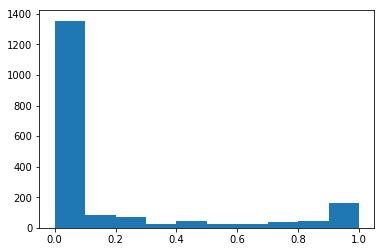

In [9]:
plt.hist(R_pred_frame_label)

In [10]:
torch.save(best_model, 'models/ts_labelmodel_best_tuning_high_pre_downsampled.pth')

# Save/Load best model

In [11]:
model = best_model

In [24]:
torch.save(model, 'models/ts_labelmodel.pth')

In [3]:
model = torch.load('models/ts_labelmodel.pth').to(device)

In [7]:
model = torch.load('models/ts_labelmodel_best_tuning_high_pre_downsampled.pth')

In [35]:
model.flip_params()

In [8]:
R_pred_frame_label = model.eval().predict_element_proba(
    MRI_data_temporal['Li_dev'].to(device)) #predict per element

for metric in ['accuracy', 'f1', 'recall', 'precision']:
    score = metric_score(Y_dev.cpu(), np.round(R_pred_frame_label), metric)
    print(f"{metric.capitalize()}: {score:.3f}")

Accuracy: 0.107
F1: 0.700
Recall: 0.736
Precision: 0.668


In [9]:
R_pred_frame_label = model.eval().predict_element_proba(
    MRI_data_temporal['Li_test'].to(device)) #predict per element

for metric in ['accuracy', 'f1', 'recall', 'precision']:
    score = metric_score(Y_test.cpu(), np.round(R_pred_frame_label), metric)
    print(f"{metric.capitalize()}: {score:.3f}")

Accuracy: 0.113
F1: 0.599
Recall: 0.542
Precision: 0.670


# Make predictions for everything and save to disk

In [13]:
import numpy as np
from scipy.sparse import csr_matrix
import scipy.sparse as sparse
import pickle
import rekall
from rekall.video_interval_collection import VideoIntervalCollection
from rekall.interval_list import IntervalList
from rekall.temporal_predicates import *
from metal.label_model.baselines import MajorityLabelVoter

## Load manually annotated data

In [14]:
with open('../../data/manually_annotated_shots.pkl', 'rb') as f:
    shots = VideoIntervalCollection(pickle.load(f))
with open('../../data/shot_detection_folds.pkl', 'rb') as f:
    shot_detection_folds = pickle.load(f)
clips = shots.dilate(1).coalesce().dilate(-1)
shot_boundaries = shots.map(
    lambda intrvl: (intrvl.start, intrvl.start, intrvl.payload)
).set_union(
    shots.map(lambda intrvl: (intrvl.end + 1, intrvl.end + 1, intrvl.payload))
).coalesce()
boundary_frames = {
    video_id: [
        intrvl.start
        for intrvl in shot_boundaries.get_intervallist(video_id).get_intervals()
    ]
    for video_id in shot_boundaries.get_allintervals()
}
video_ids = sorted(list(clips.get_allintervals().keys()))
frames_per_video = {
    video_id: sorted([
        f
        for interval in clips.get_intervallist(video_id).get_intervals()
        for f in range(interval.start, interval.end + 2)
    ])
    for video_id in video_ids
}
ground_truth = {
    video_id: [
        1 if f in boundary_frames[video_id] else 2
        for f in frames_per_video[video_id]
    ] 
    for video_id in video_ids
}

100%|██████████| 28/28 [00:00<00:00, 28637.04it/s]


## Load label matrix with all frames in it

In [15]:
with open('../../data/shot_detection_weak_labels/all_labels_high_pre.pkl', 'rb') as f:
    weak_labels_all_movies = pickle.load(f)

## Load videos and number of frames per video

In [16]:
with open('../../data/frame_counts.pkl', 'rb') as f:
    frame_counts = pickle.load(f)
video_ids_all = sorted(list(frame_counts.keys()))
video_ids_train = sorted(list(set(video_ids_all).difference(set(video_ids))))

## Construct windows for each video

In [17]:
# First, construct windows of 16 frames for each video
windows = VideoIntervalCollection({
    video_id: [
        (f, f + 16, video_id)
        for f in range(0, frame_counts[video_id] - 16, 16)
    ]
    for video_id in video_ids_all
})

## Get ground truth labels for all windows

In [18]:
# Next, intersect the windows with ground truth and get ground truth labels for the windows
windows_intersecting_ground_truth = windows.filter_against(
    clips,
    predicate=overlaps()
).map(lambda intrvl: (intrvl.start, intrvl.end, 2))
windows_with_shot_boundaries = windows_intersecting_ground_truth.filter_against(
    shot_boundaries,
    predicate = lambda window, shot_boundary:
        shot_boundary.start >= window.start and shot_boundary.start < window.end
).map(
    lambda intrvl: (intrvl.start, intrvl.end, 1)
)
windows_with_labels = windows_with_shot_boundaries.set_union(
    windows_intersecting_ground_truth
).coalesce(
    predicate = equal(),
    payload_merge_op = lambda p1, p2: min(p1, p2)
)

## Get weak labels for all windows

In [19]:
# Label windows with the weak labels in our labeling functions
def label_window(per_frame_weak_labels):
    if 1 in per_frame_weak_labels:
        return 1
    if len([l for l in per_frame_weak_labels if l == 2]) >= len(per_frame_weak_labels) / 2:
        return 2
    return 0

windows_with_weak_labels = windows.map(
    lambda window: (
        window.start,
        window.end,
        [
            label_window([
                lf[window.payload][f-1]
                for f in range(window.start, window.end)
            ])
            for lf in weak_labels_all_movies
        ]
    )
)

# L matrix

In [ ]:
L_everything_windows = csr_matrix([
    intrvl.payload
    for video_id in sorted(list(video_ids_all))
    for intrvl in windows_with_weak_labels.get_intervallist(video_id).get_intervals()
]).todense()

In [41]:
with open('../../data/shot_detection_weak_labels/L_everything_windows_high_pre_downsampled.npy', 'wb') as f:
    np.save(f, L_everything_windows)

In [20]:
with open('../../data/shot_detection_weak_labels/L_everything_windows_high_pre_downsampled.npy', 'rb') as f:
    L_everything_windows = np.load(f)

# Convert L matrix to timeseries

In [21]:
T = 5
m_per_task = L_everything_windows.shape[1]

In [22]:
L_unlabelled = torch.FloatTensor(L_everything_windows[:L_everything_windows.shape[0] -
                                                      (L_everything_windows.shape[0] % T)]).to(device)

In [23]:
m_per_task_unlabelled = L_unlabelled.size(1)
n_frames_unlabelled = L_unlabelled.size(0)
n_patients_unlabelled = n_frames_unlabelled//T

In [24]:
L_unlabelled_ts = torch.LongTensor(
    L_unlabelled.view(n_patients_unlabelled, (m_per_task*T)).cpu().numpy())

# Predict everything

In [25]:
L_unlabelled_ts.shape[0]

1235081

In [68]:
model.flip_params()

In [26]:
predictions_val = model.eval().predict_element_proba(MRI_data_temporal['Li_dev'])

(array([1355.,   85.,   73.,   26.,   45.,   25.,   28.,   40.,   47.,
         161.]),
 array([2.64933485e-07, 9.99409961e-02, 1.99881727e-01, 2.99822458e-01,
        3.99763190e-01, 4.99703921e-01, 5.99644652e-01, 6.99585383e-01,
        7.99526114e-01, 8.99466845e-01, 9.99407576e-01]),
 <a list of 10 Patch objects>)

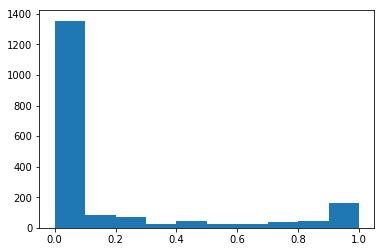

In [27]:
plt.hist(predictions_val)

In [28]:
for metric in ['accuracy', 'f1', 'recall', 'precision']:
    score = metric_score(Y_dev.cpu().where(Y_dev.cpu() == torch.tensor(1.), torch.tensor(0.)),
                         np.round(predictions_val), metric)
    print(f"{metric.capitalize()}: {score:.3f}")

Accuracy: 0.909
F1: 0.700
Recall: 0.736
Precision: 0.668


In [29]:
predictions_everything = []
for i in range(0, L_unlabelled_ts.shape[0], 100000):
    print(i)
    start = i
    end = i + 100000
    labels = L_unlabelled_ts[start:end] if end < L_unlabelled_ts.shape[0] else L_unlabelled_ts[start:]
    predictions_for_labels = model.eval().predict_element_proba(labels.to(device))
    predictions_everything.append(predictions_for_labels)
    del predictions_for_labels
    torch.cuda.empty_cache()

0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000


In [30]:
np.concatenate(predictions_everything).shape

(6175405,)

In [31]:
R_pred_probs_per_frame = np.concatenate(predictions_everything)

In [14]:
# R_pred_frame = predictions_everything_together

# #find sequence label config. with highest prob.
# config_index = np.argmax(R_pred_frame, axis=1)
# R_pred_config = model.feasible_y[config_index].detach().cpu()
# R_pred_max = torch.FloatTensor(np.max(R_pred_frame.numpy(), axis=1))

# #for each 1 in config, multiply by prob. label for sequence (1-prob label otherwise)
# R_pred_probs = torch.FloatTensor(R_pred_config.shape)
# for idx in range(R_pred_config.shape[0]):
#     R_pred_probs[idx,:] = torch.LongTensor(R_pred_config[idx,:]).float()*R_pred_max[idx]

# R_pred_probs = R_pred_probs.numpy()
# R_pred_probs[R_pred_probs < 0] = 1+R_pred_probs[R_pred_probs < 0]
# R_pred_frame_label = np.round(R_pred_probs.ravel())
# R_pred_frame_label[R_pred_frame_label == 0.] = 2.

# R_pred_probs_per_frame = R_pred_probs.ravel()

(array([4611900.,  259713.,  209570.,  127121.,  111559.,   84019.,
          91010.,   97798.,  161422.,  421293.]),
 array([2.47917929e-10, 9.99992120e-02, 1.99998424e-01, 2.99997635e-01,
        3.99996847e-01, 4.99996059e-01, 5.99995271e-01, 6.99994482e-01,
        7.99993694e-01, 8.99992906e-01, 9.99992118e-01]),
 <a list of 10 Patch objects>)

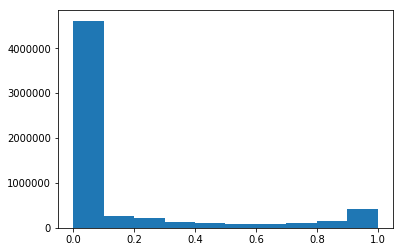

In [32]:
plt.hist(R_pred_probs_per_frame)

# Save predictions to disk

In [33]:
window_nums = [
    (video_id, intrvl.start, intrvl.end)
    for video_id in sorted(list(video_ids_all))
    for intrvl in windows_with_weak_labels.get_intervallist(video_id).get_intervals()
]

In [34]:
predictions_to_save_windows = [
    (window_info, np.array([prediction, 1. - prediction]))
    for window_info, prediction in zip(window_nums, R_pred_probs_per_frame)
]

In [35]:
# Because we needed to cut the predictions to a multiple of T
last_preds = []
for window_info in window_nums[len(predictions_to_save_windows):]:
    last_preds.append((window_info, np.array([0., 1.])))

In [36]:
last_preds

[]

In [ ]:
predictions_to_save_windows += last_preds

In [37]:
preds_np_windows = np.array(predictions_to_save_windows)

In [38]:
# save predictions to disk
with open('../../data/shot_detection_weak_labels/ts_weak_labels_all_windows_tuned_high_pre_downsampled.npy', 'wb') as f:
    np.save(f, preds_np_windows)